## Deconvolving single-cell family size distribution into chimeric and real components

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *
from fingerprint import SingleCellFingerprintBase, SingleCellFingerprintDTM
from fsd import NBMixtureFSDCodec
from dtm import DropletTimeMachineModel, PosteriorGeneExpressionSampler
from expr import VSGPGeneExpressionPrior, VSGPGeneExpressionPriorPreTrainer

import pyro
from pyro import poutine
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam, ExponentialLR
from pyro_extras import checkpoint_model, load_latest_checkpoint
from pyro_extras import ZeroInflatedNegativeBinomial

import torch

import scipy.sparse as sp
import logging
from collections import Counter
import pickle 
from scipy.signal import savgol_filter
from typing import Tuple, Set, List, Dict, Callable

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

## Inputs, outputs, and model hyperparameters

In [2]:
device = torch.device('cuda')
dtype = torch.float

# dataset_name = 'pbmc4k_ss_rate_0.25'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'
# n_gene_groups = 100

# dataset_name = 'pbmc4k_ss_rate_0.25_small'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_small_sc_fingerprint.pkl'
# n_gene_groups = 10

dataset_name = 'pbmc4k'
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'
n_gene_groups = 100

# dataset_name = 'pbmc4k_small'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_small_sc_fingerprint.pkl'
# n_gene_groups = 10

# load fingerprint and instantiate the data-store
sc_fingerprint_base = SingleCellFingerprintBase.load(sc_fingerprint_path)
sc_fingerprint_base = sc_fingerprint_base.filter_genes(
    max_good_turing=1.,
    min_total_gene_expression=1.).sort_genes_by_expression()

# gene_expr_ladder_idx_list = sc_fingerprint_base.gene_idx_list[::10]
# sc_fingerprint_base = sc_fingerprint_base.subset_genes(gene_expr_ladder_idx_list)

# Instantiate the fingerprint datastore
sc_fingerprint_dtm = SingleCellFingerprintDTM(
    sc_fingerprint_base,
    n_gene_groups=n_gene_groups,
    enable_cell_features=False,
    allow_dense_int_ndarray=False,
    device=device,
    dtype=dtype)

Calculating and caching "SingleCellFingerprintBase.good_turing_estimator_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Number of genes failed the maximum Good-Turing criterion: 13872
Number of genes failed the minimum expression criterion: 13872
Number of genes failed both criteria: 13872
Number of retained genes: 19822
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...


In [56]:
init_params_dict = {
    'global.chimera_alpha_c_prior_loc': 0.05,
    'global.chimera_alpha_c_prior_scale': 0.01,
    'global.chimera_beta_c_prior_loc': 0.05,
    'global.chimera_beta_c_prior_scale': 0.01,
    'fsd.gmm_num_components': 5,
    'fsd.gmm_dirichlet_concentration': 0.01,
    'fsd.gmm_min_weight_per_component': 0.0001,
    'fsd.gmm_min_xi_scale': 0.1,
    'fsd.gmm_max_xi_scale': None,
    'fsd.gmm_init_xi_scale': 0.2,
    'fsd.gmm_init_components_perplexity': 0.2,
    'fsd.enable_fsd_w_dirichlet_reg': True,
    'fsd.w_lo_dirichlet_reg_strength': 1.0,
    'fsd.w_hi_dirichlet_reg_strength': 1.0,
    'fsd.w_lo_dirichlet_concentration': 0.01,
    'fsd.w_hi_dirichlet_concentration': 0.01,
    'fsd.xi_posterior_min_scale': 0.0,
    'model.n_particles_fingerprint_log_like': 10,
    'expr.vsgp.n_inducing_points': 50,
    'expr.vsgp.init_rbf_kernel_variance': 0.1,
    'expr.vsgp.init_rbf_kernel_lengthscale': 0.5,
    'expr.vsgp.init_linear_kernel_variance': 0.1,
    'expr.vsgp.init_constant_kernel_variance': 0.1,
    'expr.vsgp.init_whitenoise_kernel_variance': 0.1,
    'expr.vsgp.init_beta_mean': np.asarray([0., 1., 0., 0.]),
    'expr.vsgp.cholesky_jitter': 0.001,
    'expr.vsgp.min_noise': 0.05,
}

guide_spec_dict = {
    'fsd_xi': 'gaussian',
}

fsd_init_params_dict = {
    'fsd_init.min_mu_lo': 0.02,
    'fsd_init.min_mu_hi': 0.2,
    'fsd_init.max_phi_lo': 1.5,
    'fsd_init.max_phi_hi': 0.5,
    'fsd_init.mu_decay': 0.75,
    'fsd_init.w_decay': 0.2,
    'fsd_init.mu_lo_to_mu_hi_ratio': 0.05}

default_constraint_strength = 1e5
medium_constraint_strength = 1e6
strong_constraint_strength = 1e8

model_constraint_params_dict = {
    # phi_lo is softly pinned to 1.0 (to decrease the parameter complexity of chimeras)
    'phi_fsd_lo_comps_nj': {
        'pin_value': 1.0,
        'pin_strength': strong_constraint_strength,
        'pin_exponent': 2},
    
    # no component of p_hi is allowed to be too over-dispersed
    'phi_fsd_hi_comps_nj': {
        'upper_bound_value': 1.0,
        'upper_bound_width': 0.2,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},

#     # no component of p_lo can have too small or too large of a mean family size
#     # compared to the empirical mean
#     'mu_fsd_lo_comps_to_mu_empirical_ratio_nj': {
#         'lower_bound_value': 0.001,
#         'lower_bound_width': 0.001,
#         'lower_bound_strength': default_constraint_strength,
#         'lower_bound_exponent': 2,
#         'upper_bound_value': 0.20,
#         'upper_bound_width': 0.05,
#         'upper_bound_strength': default_constraint_strength,
#         'upper_bound_exponent': 2},
    
    # no component of p_hi can have too small or too large of a mean family size
    # compared to the empirical mean
    'mu_fsd_hi_comps_to_mu_empirical_ratio_nj': {
#         'lower_bound_value': 0.2,
#         'lower_bound_width': 0.1,
#         'lower_bound_strength': default_constraint_strength,
#         'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 2.0,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},
    
#     # the ratio of observed chimeric to real molecules can not exceed a certain value
#     'p_obs_lo_to_p_obs_hi_ratio_n': {
#         'upper_bound_value': 0.2,
#         'upper_bound_width': 0.05,
#         'upper_bound_strength': default_constraint_strength,
#         'upper_bound_exponent': 2},

    # the ratio of observed chimeric to real molecules can not exceed a certain value
    'mu_fsd_lo_to_mu_fsd_hi_ratio_n': {
        'upper_bound_value': 0.1,
        'upper_bound_width': 0.02,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},
    
    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_fsd_hi_comps_nj': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.02,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2},
    
    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_fsd_lo_comps_nj': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.02,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2},

    # make sure that log_mu_e_hi is not too small or too large (to prevent over/under-flows)
    'log_mu_e_hi_n': {
        'lower_bound_value': -8.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 8.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': medium_constraint_strength,
        'upper_bound_exponent': 2},

    # make sure that log_phi_e_hi is not too small or too large (to prevent over/under-flows)
    'log_phi_e_hi_n': {
        'lower_bound_value': -8.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 8.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': medium_constraint_strength,
        'upper_bound_exponent': 2},

    # make sure that logit_p_zero_e_hi_batch is not too small or too large (to prevent over/under-flows)
    'logit_p_zero_e_hi_n': {
        'lower_bound_value': -8.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 8.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': medium_constraint_strength,
        'upper_bound_exponent': 2},
}

slow_params = {
    
}

weight_decay_params = {
    
}

slow_modules = {
    'gene_expression_prior'
}

In [57]:
root = '/home/jupyter/data/10x/out'
suffix = "all_genes__simplified_model__rc_12"

output_path = os.path.join(
    root,
    f"{dataset_name}_" +
    f"_{suffix}")

checkpoint_path = os.path.join(output_path, "checkpoints")

try:
    print(output_path)
    print(checkpoint_path)
    os.mkdir(output_path)
    os.mkdir(checkpoint_path)
except:
    pass

/home/jupyter/data/10x/out/pbmc4k__all_genes__simplified_model__rc_12
/home/jupyter/data/10x/out/pbmc4k__all_genes__simplified_model__rc_12/checkpoints


## Pretraining the SVGP gene expression prior

In [58]:
pyro.clear_param_store()

n_training_iters = 1000
print_loss_frequency = 50
minibatch_genes_per_gene_group = 20
minibatch_expressing_cells_per_gene = 20
minibatch_silent_cells_per_gene = 5
minibatch_sampling_strategy = 'without_replacement'
lr = 1e-2

vsgp_gene_expression_prior = VSGPGeneExpressionPrior(
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    n_inducing_points=init_params_dict['expr.vsgp.n_inducing_points'],
    init_rbf_kernel_variance=init_params_dict['expr.vsgp.init_rbf_kernel_variance'],
    init_rbf_kernel_lengthscale=init_params_dict['expr.vsgp.init_rbf_kernel_lengthscale'],
    init_linear_kernel_variance=init_params_dict['expr.vsgp.init_linear_kernel_variance'],
    init_constant_kernel_variance=init_params_dict['expr.vsgp.init_constant_kernel_variance'],
    init_whitenoise_kernel_variance=init_params_dict['expr.vsgp.init_whitenoise_kernel_variance'],
    init_beta_mean=init_params_dict['expr.vsgp.init_beta_mean'],
    cholesky_jitter=init_params_dict['expr.vsgp.cholesky_jitter'],
    min_noise=init_params_dict['expr.vsgp.min_noise']
)

In [59]:
vsgp_gene_expression_prior_pretrainer = VSGPGeneExpressionPriorPreTrainer(
    vsgp_gene_expression_prior)

svi = SVI(
    model=vsgp_gene_expression_prior_pretrainer.model,
    guide=vsgp_gene_expression_prior_pretrainer.guide,
    optim=pyro.optim.Adam({'lr': lr}),
    loss=Trace_ELBO())

logging.warning("[Pre-training VSGPGeneExpressionPrior] starting...")
t0 = time.time()
loss_scale = sc_fingerprint_dtm.n_genes * sc_fingerprint_dtm.n_cells
i_iter = 0
mb_loss_list = []

while i_iter < n_training_iters:
    
    # generate stratified minibatch
    mb_data = sc_fingerprint_dtm.generate_stratified_sample_torch(
        minibatch_genes_per_gene_group,
        minibatch_expressing_cells_per_gene,
        minibatch_silent_cells_per_gene,
        minibatch_sampling_strategy)

    # SVI update
    mb_loss = svi.step(mb_data)
    mb_loss_list.append(mb_loss / loss_scale)
    i_iter += 1

    if i_iter % print_loss_frequency == 0 and i_iter > 0:

        # calculate loss stats
        t1 = time.time()
        mb_loss_mean, mb_loss_std = np.mean(mb_loss_list), np.std(mb_loss_list)
        
        logging.warning(
            f'Iteration number: {i_iter}, loss: {mb_loss_mean:.3f} +- {mb_loss_std:.3f}, '
            f'time: {(t1 - t0):.3f}s')
        
        # reset
        mb_loss_list = []
        t0 = t1

logging.warning("[Pre-training VSGPGeneExpressionPrior] finished!")

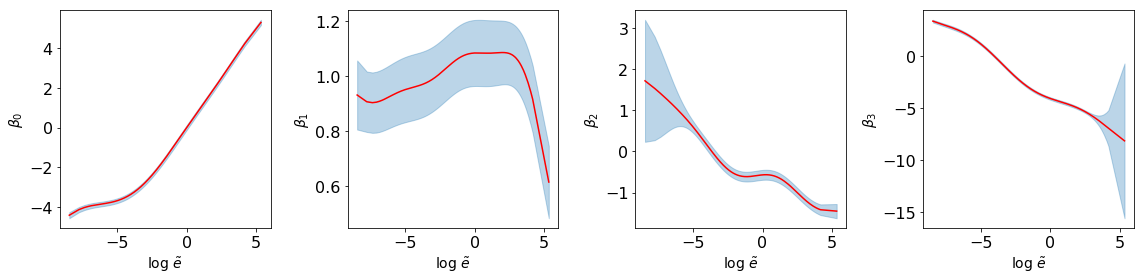

In [60]:
vsgp_gene_expression_prior.plot_beta(plt)

## Training the Droplet Time Machine (TM)

In [61]:
n_training_iters = 15_000

minibatch_genes_per_gene_group = 50
minibatch_expressing_cells_per_gene = 25
minibatch_silent_cells_per_gene = 5
minibatch_sampling_strategy = 'without_replacement'

slow_params_lr_reduction_factor = 0.2
slow_modules_lr_reduction_factor = 0.2
weight_decay = 0.0
adam_lr_start = 1e-2
adam_lr_stop = 1e-3
adam_betas = (0.95, 0.995)
adam_eps = 1e-6

In [62]:
pyro.clear_param_store()

gene_expression_prior = vsgp_gene_expression_prior

fsd_codec = NBMixtureFSDCodec(
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    n_fsd_lo_comps=1,
    n_fsd_hi_comps=2,
    fsd_init_params_dict=fsd_init_params_dict,
    device=device,
    dtype=dtype)

model = DropletTimeMachineModel(
    init_params_dict=init_params_dict,
    model_constraint_params_dict=model_constraint_params_dict,
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    gene_expression_prior=gene_expression_prior,
    fsd_codec=fsd_codec,
    guide_spec_dict=guide_spec_dict,
    device=device,
    dtype=dtype)

def get_adam_args(
    base_lr: float,
    slow_params_base_lr: float,
    slow_modules_base_lr: float,
    slow_params: Set[str],
    slow_modules: Set[str],
    weight_decay_params: Set[str],
    weight_decay: float,
    adam_eps: float,
    adam_betas: Tuple[float, float]) -> Callable:
    
    def adam_args(module_name, param_name):
        if module_name in slow_modules:
            lr = slow_modules_base_lr
        elif param_name in slow_params:
            lr = slow_params_base_lr
        else:
            lr = base_lr
            
        if param_name in weight_decay_params:
            weight_decay = weight_decay
        else:
            weight_decay = 0
            
        return {
            'lr': lr,
            'eps': adam_eps,
            'betas': adam_betas,
            'weight_decay': weight_decay,
        }

    return adam_args

adam_args = get_adam_args(
    base_lr=adam_lr_start,
    slow_params_base_lr=slow_params_lr_reduction_factor * adam_lr_start,
    slow_modules_base_lr=slow_modules_lr_reduction_factor * adam_lr_start,
    slow_params=slow_params,
    slow_modules=slow_modules,
    weight_decay_params=weight_decay_params,
    weight_decay=weight_decay,
    adam_eps=adam_eps,
    adam_betas=adam_betas)

optimizer = torch.optim.Adam
adam_lr_decay_per_iter = np.exp(np.log(adam_lr_stop / adam_lr_start) / n_training_iters)

scheduler = pyro.optim.ExponentialLR({
    'optimizer': optimizer,
    'optim_args': adam_args,
    'gamma': adam_lr_decay_per_iter})

svi = SVI(
    model=model.model,
    guide=model.guide,
    optim=scheduler,
    loss=Trace_ELBO())

In [63]:
i_iter = 0
loss_hist = []
# load_latest_checkpoint(checkpoint_path)

In [64]:
# model_output_path = os.path.join(
#     output_path,
#     f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
# pyro.get_param_store().load(model_output_path)

In [96]:
print_loss_frequency = 50
checkpoint_frequency = 1_000

mb_loss_list = []
fsd_abs_res_list = []
loss_scale_factor = 1. / (sc_fingerprint_dtm.n_cells * sc_fingerprint_dtm.n_genes)
prev_fsd_xi_posterior_loc = torch.zeros(
    (sc_fingerprint_dtm.n_genes, fsd_codec.total_fsd_params),
    dtype=dtype, device=device)

t0 = time.time()

while i_iter < n_training_iters:
    
    # generate stratified minibatch
    mb_data = sc_fingerprint_dtm.generate_stratified_sample_torch(
        minibatch_genes_per_gene_group,
        minibatch_expressing_cells_per_gene,
        minibatch_silent_cells_per_gene,
        minibatch_sampling_strategy)

    # SVI update
    mb_loss = svi.step(mb_data)
    scheduler.step(epoch=i_iter)
    i_iter += 1
        
    # bookkeeping, history tracking, etc.
    mb_loss_per_cell_gene = loss_scale_factor * mb_loss
    mb_loss_list.append(mb_loss_per_cell_gene)
    loss_hist.append(mb_loss_per_cell_gene)
    
    # calculate change in fsd parameters
    new_fsd_xi_posterior_loc = pyro.param("fsd_xi_posterior_loc_gq").clone().detach()
    xi_posterior_abs_res_mean = torch.mean((new_fsd_xi_posterior_loc - prev_fsd_xi_posterior_loc).abs()).item()
    prev_fsd_xi_posterior_loc = new_fsd_xi_posterior_loc    
    fsd_abs_res_list.append(1_000 * xi_posterior_abs_res_mean)
    
    if i_iter % print_loss_frequency == 0 and i_iter > 0:

        # calculate loss stats
        t1 = time.time()
        mb_loss_mean, mb_loss_std = np.mean(mb_loss_list), np.std(mb_loss_list)
        fsd_abs_res_mean, fsd_abs_res_std = np.mean(fsd_abs_res_list), np.std(fsd_abs_res_list)
        
        logging.warning(
            f'Iteration number: {i_iter}, loss: {mb_loss_mean:.3f} +- {mb_loss_std:.3f}, '
            f'fsd_abs_res: {fsd_abs_res_mean:.4f} +- {fsd_abs_res_std:.4f}, '
            f'time: {(t1 - t0):.3f}s')
        
        # reset
        mb_loss_list = []
        fsd_abs_res_list = []
        t0 = t1

    if i_iter % checkpoint_frequency == 0:
        logging.warning("Checkpointing the latest model parameters...")
        checkpoint_model(checkpoint_path)

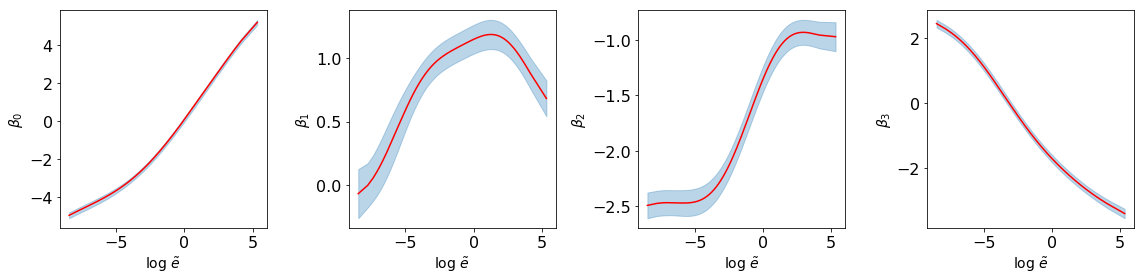

In [118]:
vsgp_gene_expression_prior.plot_beta(plt)

In [134]:
gene_expression_prior.vsgp.kernel.kern1.kern1.kern1.variance

tensor(0.3685, device='cuda:0')

In [125]:
pyro.param("alpha_c_posterior_loc")

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)

In [126]:
pyro.param("beta_c_posterior_loc")

tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)

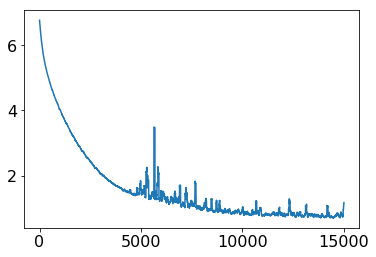

In [129]:
smoothing = True
log = True
window_length = 51
polyorder = 1

if smoothing and len(loss_hist) > window_length:
    smooth_loss_hist = savgol_filter(
        loss_hist,
        window_length=window_length,
        polyorder=polyorder)
else:
    smooth_loss_hist = loss_hist
if log:
    smooth_loss_hist = np.log1p(smooth_loss_hist)

ax = plt.gca()
ax.plot(smooth_loss_hist)

## Exploration

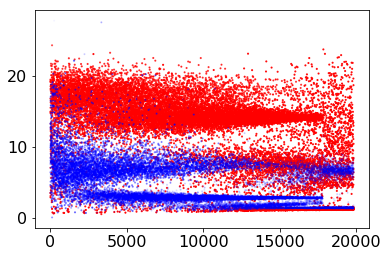

In [135]:
with torch.no_grad():
    fsd_params_dict = fsd_codec.decode(fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq")))
    empirical_mu = torch.tensor(sc_fingerprint_dtm.empirical_fsd_mu_hi).float().cuda().unsqueeze(-1)
    mu_hi = fsd_params_dict['mu_hi'].cpu().numpy()
    w_hi = fsd_params_dict['w_hi'].cpu().numpy()
    x = np.arange(sc_fingerprint_dtm.n_genes)
    
    rgba_colors_1 = np.zeros((sc_fingerprint_dtm.n_genes, 4))
    rgba_colors_1[:, 0] = 1.0
    rgba_colors_1[:, 3] = w_hi[:, 0]

    rgba_colors_2 = np.zeros((sc_fingerprint_dtm.n_genes, 4))
    rgba_colors_2[:, 2] = 1.0
    rgba_colors_2[:, 3] = w_hi[:, 1]

    plt.scatter(x, mu_hi[:, 0], marker='.', s=5, color=rgba_colors_1)
    plt.scatter(x, mu_hi[:, 1], marker='.', s=5, color=rgba_colors_2)
    # plt.ylim([0, 5])

mean_e_obs: 207.37343517929133
mean_e_hi (map): 202.72947167409293
e_hi_z: 22
e_obs_z: 4
mu_e_hi (prior): 171.29087829589844
phi_e_hi (prior): 0.37879905104637146
p_zero_e_hi (prior): 0.03246888145804405
mean_e_hi (prior): 165.72926330566406
p_obs_hi: 0.987 +- 0.000


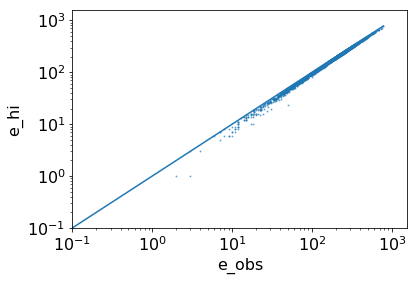

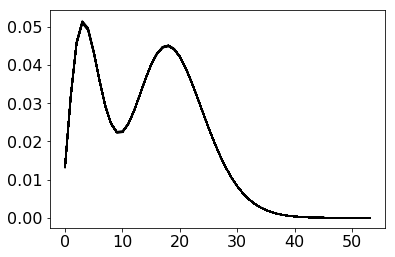

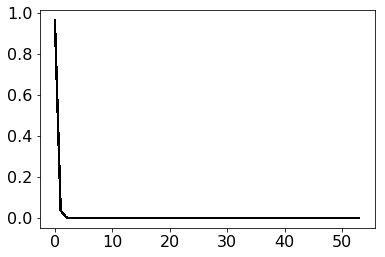

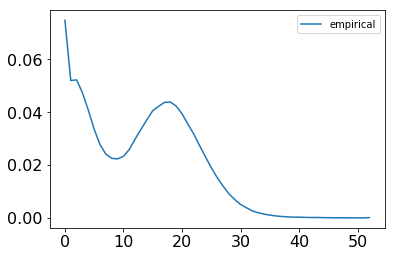

In [136]:
gene_index = 0  #sc_fingerprint_base.gene_idx_list.index(5718)

sampler = PosteriorGeneExpressionSampler(model, device, dtype)
expr_dict = sampler.get_gene_expression_posterior_sampling_summary(
    gene_index=gene_index,
    n_proposals_omega=20,
    n_particles_omega=10,
    n_particles_cell=10,
    n_particles_expression=10,
    cell_shard_size=100,
    run_mode="full",
    only_expressing_cells=False)
# expr_dict =  sampler.get_gene_expression_posterior_moments_summary(
#     gene_index=gene_index,
#     n_particles_omega=100,
#     n_particles_cell=1,
#     cell_shard_size=1000,
#     only_expressing_cells=False,
#     run_mode='full',
#     mode_estimation_strategy='lower_bound')

e_hi = expr_dict['e_hi_map']



data = sc_fingerprint_dtm.generate_single_gene_minibatch_data(
    gene_index, np.arange(0, sc_fingerprint_dtm.n_cells), 1)
beta_loc_nr, _ = gene_expression_prior.forward(data)
eta_n = data['total_obs_molecules_per_cell_tensor'] / model.mean_total_molecules_per_cell
mu_e_hi_n = torch.exp(beta_loc_nr[:, 0] + beta_loc_nr[:, 1] * eta_n.log())
phi_e_hi_n = beta_loc_nr[:, 2].exp()
logit_p_zero_e_hi_n = beta_loc_nr[:, 3]

e_hi_prior_dist = ZeroInflatedNegativeBinomial(
    logit_p_zero=logit_p_zero_e_hi_n,
    mu=mu_e_hi_n,
    phi=phi_e_hi_n)



e_obs = np.asarray(sc_fingerprint_dtm.sparse_count_matrix_csc[:, gene_index].todense()).squeeze(1)
mean_e_obs = np.mean(e_obs)
mean_e_hi = np.mean(e_hi)
e_hi_z = np.sum(e_hi == 0)
e_obs_z = np.sum(e_obs == 0)

print('mean_e_obs:', mean_e_obs)
print('mean_e_hi (map):', mean_e_hi)
print('e_hi_z:', e_hi_z)
print('e_obs_z:', e_obs_z)
print('mu_e_hi (prior):', mu_e_hi_n.mean().item())
print('phi_e_hi (prior):', phi_e_hi_n.mean().item())
print('p_zero_e_hi (prior):', torch.sigmoid(logit_p_zero_e_hi_n).mean().item())
print('mean_e_hi (prior):', e_hi_prior_dist.mean.mean().item())


fig = plt.figure()
plt.scatter(e_obs, e_hi, s=1, alpha=0.5)
plt.plot([0.1, np.max(e_obs)], [0.1, np.max(e_obs)])
plt.xlabel('e_obs', fontsize=16)
plt.ylabel('e_hi', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.1, 2*np.max(e_obs)))
plt.ylim((0.1, 2*np.max(e_obs)))

n_posterior_samples = 500
cell_index_array = np.zeros((n_posterior_samples,), dtype=np.int).astype(np.int32)
gene_index_array = gene_index * np.ones_like(cell_index_array).astype(np.int32)
cell_sampling_site_scale_factor_array = np.ones_like(cell_index_array)
gene_sampling_site_scale_factor_array = np.ones_like(cell_index_array)
single_gene_mb_data = sc_fingerprint_dtm.generate_torch_minibatch_data(
    cell_index_array,
    gene_index_array,
    cell_sampling_site_scale_factor_array,
    gene_sampling_site_scale_factor_array,
    np.zeros((n_posterior_samples, sc_fingerprint_dtm.max_family_size), dtype=np.float32))
guide_trace = poutine.trace(model.guide).get_trace(single_gene_mb_data)
fsd_params_dict = fsd_codec.decode(guide_trace.nodes["fsd_xi_nq"]["value"])

dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict)
p_lo = dist_lo.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()
p_hi = dist_hi.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()

p_obs_hi_mean, p_obs_hi_std = np.mean(1 - p_hi[:, 0]), np.std(p_hi[:, 0])
print(f"p_obs_hi: {p_obs_hi_mean:.3f} +- {p_obs_hi_std:.3f}")

fig = plt.figure()
for i in range(n_posterior_samples):
    plt.plot(p_hi[i, :], alpha=0.05, color='black')

fig = plt.figure()
for i in range(n_posterior_samples):
    plt.plot(p_lo[i, :], alpha=0.05, color='black')


empircal_fsd = sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index, None)
empircal_fsd = empircal_fsd / (1e-12 + np.sum(empircal_fsd, -1)[:, None])
empircal_fsd = np.sum(empircal_fsd, 0)
empircal_fsd = empircal_fsd / np.sum(empircal_fsd)

plt.figure()
plt.plot(empircal_fsd, label='empirical')
# plt.plot(model_fsd, label='model')
plt.legend()

(0, 1917.5)

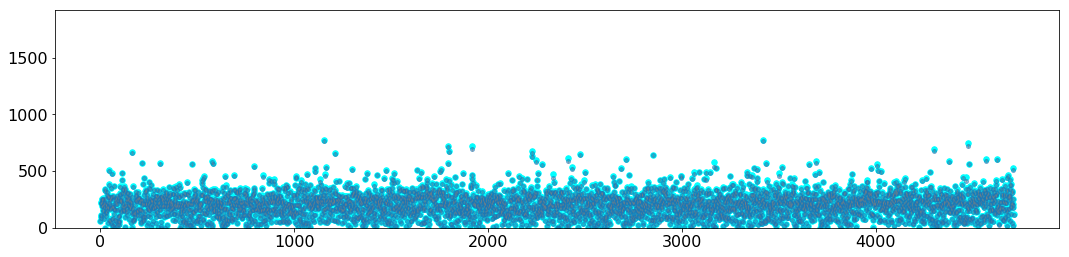

In [137]:
plt.figure(figsize=(18,4))

err = 3 * expr_dict['e_hi_std']
plt.scatter(np.arange(0, sc_fingerprint_dtm.n_cells), e_obs, marker='o', color='cyan', s=30)
plt.errorbar(np.arange(0, sc_fingerprint_dtm.n_cells),
             expr_dict['e_hi_map'],
             barsabove=True, elinewidth=1, lw=0,
             marker='.', ecolor='gray', markersize=8,
             yerr=err, alpha=0.5)
plt.ylim((0, 2.5 * np.max(expr_dict['e_hi_map'])))
# plt.scatter(np.arange(0, sc_fingerprint_dtm.n_cells), expr_dict['e_hi_mean'], marker='x', color='red', s=8)


In [138]:
np.any((e_hi > 0) & (e_obs == 0))

False

Text(0.5, 0, '$e_\\mathrm{obs}$')

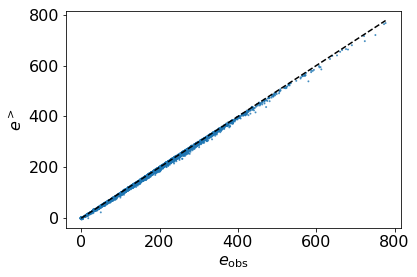

In [139]:
from collections import Counter
x_vals = e_obs
y_vals = expr_dict['e_hi_map']
combos = list(zip(x_vals, y_vals))
weight_counter = Counter(combos)
weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


plt.scatter(x_vals, y_vals, s=weights, alpha=0.7)
plt.plot([0, np.max(x_vals)], [0, np.max(x_vals)], '--', color='black')
plt.ylabel(r'$e^>$', fontsize=16)
plt.xlabel(r'$e_\mathrm{obs}$', fontsize=16)

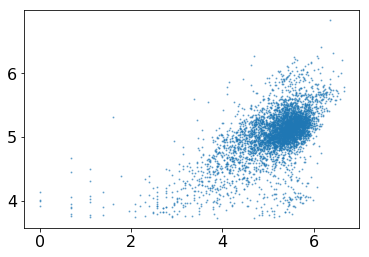

In [140]:
plt.scatter(
    np.log1p(e_obs),
    np.log1p(e_hi_prior_dist.mean.detach().cpu().numpy()), s=1, alpha=0.5)

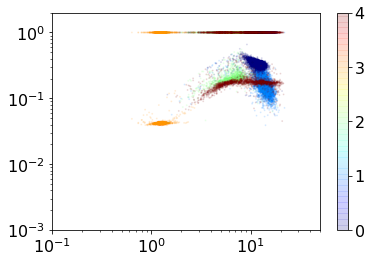

In [141]:
with torch.no_grad():
    fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc_gq"))
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict, downsampling_rate_tensor=None)
    mu_lo = dist_lo.mean.cpu().numpy()
    mu_hi = dist_hi.mean.cpu().numpy()
    phi_lo = fsd_params_dict['phi_lo'].squeeze(-1).cpu().numpy()
    
assignments = torch.argmin(
    (fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq")).unsqueeze(-1)
     - fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs_kq")).permute(-1, -2)).pow(2).sum(1), dim=-1).detach().cpu().numpy()

plt.scatter(mu_hi.squeeze(), mu_lo.squeeze(), s=1, alpha=0.1, c=assignments, cmap=plt.cm.jet)
plt.scatter(mu_hi.squeeze(), phi_lo.squeeze(), s=1, alpha=0.1, c=assignments, cmap=plt.cm.jet)
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-3, 2.))
plt.xlim((0.1, 50)) 
plt.colorbar()

In [89]:
# mu_e_hi_g, phi_e_hi_g, logit_p_zero_e_hi_g = model._decode_e_hi_zeta(
#     pyro.param("e_hi_zeta_posterior_loc_gr"))
# logit_p_zero_e_hi = logit_p_zero_e_hi_g.detach().cpu().numpy()
# _ = plt.hist(logit_p_zero_e_hi, bins=400)

In [90]:
# plt.scatter(np.log(mu_e_hi_g.detach().cpu().numpy()), logit_p_zero_e_hi_g.detach().cpu().numpy(), alpha=0.1, s=1)

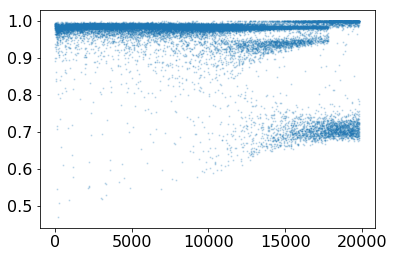

In [102]:
from pyro_extras import get_log_prob_compl

with torch.no_grad():
    xi_posterior = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq"))
    zero = torch.tensor(0, device=device, dtype=dtype)
    fsd_params_dict = fsd_codec.decode(xi_posterior)

    # get chimeric and real family size distributions
    fsd_lo_dist, fsd_hi_dist = fsd_codec.get_fsd_components(fsd_params_dict)

    # extract required quantities from the distributions
    mu_fsd_lo_g = fsd_lo_dist.mean.squeeze(-1)
    mu_fsd_hi_g = fsd_hi_dist.mean.squeeze(-1)
    log_p_unobs_lo_g = fsd_lo_dist.log_prob(zero).squeeze(-1)
    log_p_unobs_hi_g = fsd_hi_dist.log_prob(zero).squeeze(-1)
    log_p_obs_lo_g = get_log_prob_compl(log_p_unobs_lo_g)
    log_p_obs_hi_g = get_log_prob_compl(log_p_unobs_hi_g)
    p_obs_lo_g = log_p_obs_lo_g.exp()
    p_obs_hi_g = log_p_obs_hi_g.exp()
    
plt.scatter(np.arange(sc_fingerprint_dtm.n_genes), p_obs_hi_g.cpu().numpy(), alpha=0.2, s=1)

## Visualizing the distributions parameters $\xi$

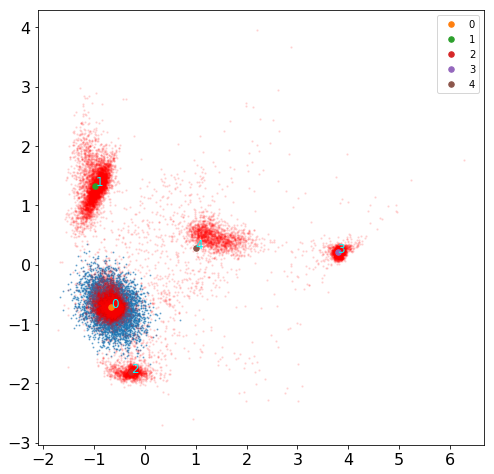

In [114]:
import pyro.distributions as dist
from pyro_extras import MixtureDistribution
from sklearn.decomposition import PCA

n_prior_samples = 5_000

with torch.no_grad():
    xi_posterior = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq")).detach().cpu().numpy()
    
    fsd_xi_prior_locs = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs_kq"))
    fsd_xi_prior_scales = pyro.param("fsd_xi_prior_scales_kq")
    fsd_xi_prior_dist = model._get_fsd_xi_prior_dist(fsd_xi_prior_locs, fsd_xi_prior_scales)
    xi_prior = fsd_xi_prior_dist.sample((n_prior_samples,)).cpu().numpy()
    

pca = PCA(n_components=2)
xi_prior_pca_fit = pca.fit(xi_posterior)
xi_prior_pca = xi_prior_pca_fit.transform(xi_prior)
xi_posterior_pca = xi_prior_pca_fit.transform(xi_posterior)
xi_prior_locs_pca = xi_prior_pca_fit.transform(pyro.param("fsd_xi_prior_locs_kq").detach().cpu().numpy())


fig = plt.figure(figsize=(8, 8))
plt.scatter(xi_prior_pca[:, 0], xi_prior_pca[:, 1], alpha=0.5, s=1)
plt.scatter(xi_posterior_pca[:, 0], xi_posterior_pca[:, 1], alpha=0.1, s=2, color='red')
for j in range(model.fsd_gmm_num_components):
    plt.scatter(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], s=30, marker='o', label=str(j))
    plt.text(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], str(j), color='cyan', size=12)
plt.legend()


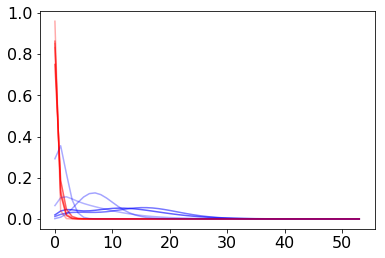

In [115]:
fig = plt.figure()

for fsd_gmm_comp_idx in range(5):
    fsd_xi = pyro.param("fsd_xi_prior_locs_kq")[fsd_gmm_comp_idx, :]
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_codec.decode(fsd_xi), None)
    max_fs = sc_fingerprint_dtm.max_family_size + 1

    p_hi = dist_hi.log_prob(torch.arange(0, max_fs).float().cuda()).detach().cpu().exp().numpy().flatten()
    p_lo = dist_lo.log_prob(torch.arange(0, max_fs).float().cuda()).detach().cpu().exp().numpy().flatten()
#     plt.plot(p_hi, color='blue')
#     plt.plot(p_lo, color='red')
#     plt.yscale('log')
    plt.plot(p_hi, color='blue', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map_k")[fsd_gmm_comp_idx].item()))
    plt.plot(p_lo, color='red', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map_k")[fsd_gmm_comp_idx].item()))

## Save Model

In [98]:
model_output_path = os.path.join(
    output_path,
    f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
pyro.get_param_store().save(model_output_path)

## Extract and save gene expression posterior

In [99]:
sampler = PosteriorGeneExpressionSampler(model, device, dtype)

run_mode = 'full'
only_expressing_cells = False

n_proposals_omega = 30
n_particles_omega = 10
n_particles_cell = 20
n_particles_expression = 20
cell_shard_size = 500
log_frequency = 10

suffix = ''
if run_mode == 'only_observed':
    suffix = 'only_observed'
elif run_mode == 'full':
    suffix = 'full'

In [ ]:
# e_hi_map = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.int)
# e_hi_mean = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.float32)
# e_hi_std = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.float32)

t0 = time.time()

for i_gene in range(9000, sc_fingerprint_dtm.n_genes):
#     expr_dict = sampler.get_gene_expression_posterior_moments_summary(
#         gene_index=i_gene,
#         n_particles_omega=n_particles_omega,
#         n_particles_cell=n_particles_cell,
#         cell_shard_size=cell_shard_size,
#         run_mode=run_mode,
#         only_expressing_cells=only_expressing_cells)
    
    adaptive_cell_shard_size = cell_shard_size
    expr_dict = None
    
    while True:
        try:
            expr_dict = sampler.get_gene_expression_posterior_sampling_summary(
                gene_index=i_gene,
                n_proposals_omega=n_proposals_omega,
                n_particles_omega=n_particles_omega,
                n_particles_cell=n_particles_cell,
                n_particles_expression=n_particles_expression,
                cell_shard_size=adaptive_cell_shard_size,
                run_mode=run_mode,
                only_expressing_cells=only_expressing_cells)
        except (RuntimeError, ValueError):
            logging.warning("CUDA out of memory -- reducing cell shard size and retrying...")
            adaptive_cell_shard_size = int(np.ceil(adaptive_cell_shard_size / 2))
        
        if expr_dict is not None:
            break
            
        if adaptive_cell_shard_size == 1:
            raise RuntimeError("Buy a better GPU!")

    e_hi_map[:, i_gene] = expr_dict['e_hi_map']
    e_hi_mean[:, i_gene] = expr_dict['e_hi_mean']
    e_hi_std[:, i_gene] = expr_dict['e_hi_std']
    
    if i_gene % log_frequency == 0 and i_gene > 0:
        t1 = time.time()
        seconds_per_gene = (t1 - t0) / log_frequency
        t0 = t1
        logging.warning(f'Processing gene {i_gene+1}/{sc_fingerprint_dtm.n_genes} ({seconds_per_gene:.2f} s/gene)...')

# gene indices and cell barcodes
original_gene_indices = np.asarray(sc_fingerprint_dtm.sc_fingerprint_base.gene_idx_list)
cell_barcodes = np.asarray(sc_fingerprint_dtm.sc_fingerprint_base.barcode_list)

# save
np.save(os.path.join(output_path, f'e_hi_map__{suffix}.npy'), e_hi_map)
np.save(os.path.join(output_path, f'e_hi_mean__{suffix}.npy'), e_hi_mean)
np.save(os.path.join(output_path, f'e_hi_std__{suffix}.npy'), e_hi_std)
np.save(os.path.join(output_path, 'gene_indices.npy'), original_gene_indices)
np.save(os.path.join(output_path, 'cell_barcodes.npy'), cell_barcodes)

In [ ]:
# single_gene_data = sampler._generate_single_gene_minibatch_data(
#     gene_index=18848,
#     cell_index_list=np.random.randint(
#         low=0, high=sc_fingerprint_dtm.n_cells, size=n_fsd_posterior_samples),
#     n_particles_cell=1)
# ctx = sampler._get_trained_model_context(single_gene_data)
# np.where(np.sum(e_hi_map, axis=0) == 0)

# out2 = sampler.get_gene_expression_posterior_sampling_summary(
#     gene_index=18848,
#     n_proposals_omega=100,
#     n_particles_omega=50,
#     n_particles_cell=50,
#     n_particles_expression=50,
#     cell_shard_size=100,
#     run_mode=run_mode,
#     only_expressing_cells=True)

# out = sampler.get_gene_expression_posterior_moments_summary(
#     18848, 10, 10, 100, False, 'full')

In [ ]:
from pyro_extras import get_log_prob_compl

n_fsd_posterior_samples = 1000

zero = torch.tensor(0, device=device, dtype=dtype)
p_obs_lo_mean_array = np.zeros((sc_fingerprint_dtm.n_genes,))
p_obs_hi_mean_array = np.zeros((sc_fingerprint_dtm.n_genes,))
p_obs_lo_std_array = np.zeros((sc_fingerprint_dtm.n_genes,))
p_obs_hi_std_array = np.zeros((sc_fingerprint_dtm.n_genes,))

with torch.no_grad():
    for gene_index in range(sc_fingerprint_dtm.n_genes):
        single_gene_data = sc_fingerprint_dtm.generate_single_gene_minibatch_data(
            gene_index=gene_index,
            cell_index_list=np.random.randint(
                low=0, high=sc_fingerprint_dtm.n_cells, size=n_fsd_posterior_samples),
            n_particles_cell=1)
        guide_trace = poutine.trace(model.guide).get_trace(single_gene_data)
        fsd_params_dict = fsd_codec.decode(guide_trace.nodes['fsd_xi_nq']['value'])

        # get chimeric and real family size distributions
        fsd_lo_dist, fsd_hi_dist = fsd_codec.get_fsd_components(fsd_params_dict)

        # extract required quantities from the distributions
        mu_fsd_lo_g = fsd_lo_dist.mean.squeeze(-1)
        mu_fsd_hi_g = fsd_hi_dist.mean.squeeze(-1)
        
        log_p_unobs_lo_g = fsd_lo_dist.log_prob(zero).squeeze(-1)
        log_p_unobs_hi_g = fsd_hi_dist.log_prob(zero).squeeze(-1)
        
        log_p_obs_lo_g = get_log_prob_compl(log_p_unobs_lo_g)
        log_p_obs_hi_g = get_log_prob_compl(log_p_unobs_hi_g)
        
        p_obs_lo_g = log_p_obs_lo_g.exp()
        p_obs_hi_g = log_p_obs_hi_g.exp()
        
        p_obs_lo_mean_array[gene_index] = torch.mean(p_obs_lo_g)
        p_obs_hi_mean_array[gene_index] = torch.mean(p_obs_hi_g)

        p_obs_lo_std_array[gene_index] = torch.std(p_obs_lo_g)
        p_obs_hi_std_array[gene_index] = torch.std(p_obs_hi_g)

np.save(os.path.join(output_path, 'p_obs_lo_mean.npy'), p_obs_lo_mean_array)
np.save(os.path.join(output_path, 'p_obs_hi_mean.npy'), p_obs_hi_mean_array)
np.save(os.path.join(output_path, 'p_obs_lo_std.npy'), p_obs_lo_std_array)
np.save(os.path.join(output_path, 'p_obs_hi_std.npy'), p_obs_hi_std_array)

In [ ]:
# from pyro_extras import ZeroInflatedNegativeBinomial

# e_hi_prior_mean = np.zeros((sc_fingerprint_dtm.n_genes,))
# e_hi_prior_std = np.zeros((sc_fingerprint_dtm.n_genes,))

# for gene_index in range(sc_fingerprint_dtm.n_genes):
#     with torch.no_grad():    
#         single_gene_data = sampler._generate_single_gene_minibatch_data(
#             gene_index=gene_index,
#             cell_index_list=np.arange(0, sc_fingerprint_dtm.n_cells),
#             n_particles_cell=1)

#         e_hi_zinb_param_dict = gene_expression_prior.forward(
#             gene_index_tensor_n=single_gene_data['gene_index_tensor'],
#             cell_index_tensor_n=single_gene_data['cell_index_tensor'],
#             eta_n=(single_gene_data['total_obs_molecules_per_cell_tensor']
#                    / model.mean_total_molecules_per_cell),
#             cell_features_nf=single_gene_data['cell_features_tensor'],
#             total_obs_reads_per_cell_tensor_n=single_gene_data['total_obs_reads_per_cell_tensor'],
#             downsampling_rate_tensor_n=single_gene_data['downsampling_rate_tensor'])

#         e_hi_prior_dist = ZeroInflatedNegativeBinomial(
#             logit_zero=e_hi_zinb_param_dict['logit_p_zero_e_hi_n'],
#             mu=e_hi_zinb_param_dict['log_mu_e_hi_n'].exp(),
#             phi=e_hi_zinb_param_dict['log_phi_e_hi_n'].exp())

#         mu_n = e_hi_prior_dist.mean
#         var_n = e_hi_prior_dist.variance

#         mean_e_hi_cell_marginalized = torch.mean(mu_n)
#         std_e_hi_cell_marginalized = torch.clamp(
#             torch.mean(var_n + mu_n.pow(2)) - mean_e_hi_cell_marginalized.pow(2),
#             min=0).sqrt()
        
#     e_hi_prior_mean[gene_index] = mean_e_hi_cell_marginalized.item()
#     e_hi_prior_std[gene_index] = std_e_hi_cell_marginalized.item()
    
# np.save(os.path.join(output_path, 'e_hi_prior_mean.npy'), e_hi_prior_mean)
# np.save(os.path.join(output_path, 'e_hi_prior_std.npy'), e_hi_prior_std)

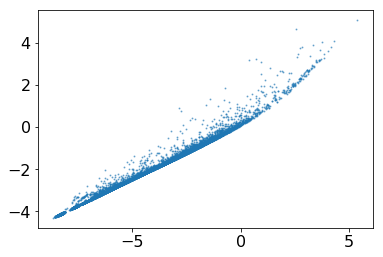

In [318]:
plt.scatter(
    np.log(e_hi_prior_mean), np.log(e_hi_prior_std), alpha=0.5, s=1)

In [ ]:
# mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(1, 10, 15)
# trace = poutine.trace(model.model).get_trace(mb_data)
# print(trace.format_shapes())

# with torch.no_grad():
#     # adapt model parameters to downsampled dataset
#     fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))

#     kappa = 0.25
#     downsampled_fsd_params_dict = dict()
#     downsampled_fsd_params_dict['phi_lo'] = fsd_params_dict['phi_lo']
#     downsampled_fsd_params_dict['phi_hi'] = fsd_params_dict['phi_hi']
#     downsampled_fsd_params_dict['w_lo'] = fsd_params_dict['w_lo']
#     downsampled_fsd_params_dict['w_hi'] = fsd_params_dict['w_hi']
#     downsampled_fsd_params_dict['mu_lo'] = kappa * fsd_params_dict['mu_lo']
#     downsampled_fsd_params_dict['mu_hi'] = kappa * fsd_params_dict['mu_hi']
#     downsampled_fsd_xi_posterior_loc = fsd_codec.encode(downsampled_fsd_params_dict)
    
# pyro.get_param_store()['fsd_xi_posterior_loc'].data.copy_(downsampled_fsd_xi_posterior_loc.data)

# # reset e_hi parameters to the initial estimate
# from pyro_extras import logit
# with torch.no_grad():
#     pyro.get_param_store()._params['mu_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_mu_e_hi).log())
#     pyro.get_param_store()._params['phi_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_phi_e_hi).log())
#     pyro.get_param_store()._params['logit_p_zero_e_hi'].data.copy_(logit(torch.tensor(sc_fingerprint_datastore.estimated_p_zero_e_hi)))

# pyro.get_param_store()._params['beta_c'].data.copy_(torch.tensor(1.).log())

In [239]:
# gene_index = 2
# mb_data = _generate_single_gene_minibatch_data(
#     gene_index,
#     np.arange(0, sc_fingerprint_dtm.n_cells), 1)

# with torch.no_grad():
#     beta_loc_rn, beta_var_rn = simple_model.gene_expr_model.guide(mb_data)        
#     beta_loc_nr = beta_loc_rn.permute(-1, -2)
#     beta_scale_nr = beta_var_rn.permute(-1, -2).sqrt()

#     beta_nr = pyro.sample(
#         "beta_nr",
#         dist.Normal(loc=beta_loc_nr, scale=beta_scale_nr).to_event(1))

#     eta_n = (mb_data['total_obs_molecules_per_cell_tensor']
#              / np.mean(sc_fingerprint_dtm.total_obs_molecules_per_cell))

#     mu_n = (beta_nr[:, 0] + beta_nr[:, 1] * eta_n.log()).exp()
#     phi_n = beta_nr[:, 2].exp()
#     logit_p_zero_n = beta_nr[:, 3]
#     mean_n = ZeroInflatedNegativeBinomial(logit_zero=logit_p_zero_n, mu=mu_n, phi=phi_n).mean
    
# plt.figure()
# _ = plt.hist(mean_n.cpu().numpy(), range=(0, 1000), bins=100)

# plt.figure()
# empirical = np.asarray(
#     sc_fingerprint_dtm.sparse_count_matrix_csc[:, gene_index].todense())
# _ = plt.hist(empirical, range=(0, 1000), bins=100)

In [5]:
# from pyro_extras import ZeroInflatedNegativeBinomial
# from torch.distributions.utils import broadcast_all
# from pyro_extras import get_log_prob_compl, logaddexp

# gene_expression_prior = SingleCellFeaturePredictedGeneExpressionPriorNew(
#     sc_fingerprint_dtm=sc_fingerprint_dtm,
#     hidden_dims=(),
#     hidden_activation=torch.nn.SELU(),
#     device=device,
#     dtype=dtype)
# # gene_expression_prior.load_state_dict(torch.load("pretrained.pt"))
# # gene_expression_prior.logit_p_zero_e_hi_g.data.copy_(-2 * torch.ones((sc_fingerprint_dtm.n_genes,)))
# # gene_expression_prior.log_phi_e_hi_g.data.copy_(-2 * torch.ones((sc_fingerprint_dtm.n_genes,)))

# dense_count_matrix = np.asarray(
#     sc_fingerprint_dtm.sparse_family_size_truncated_count_matrix_csr.todense()).astype(np.float)

In [6]:
# # minibatch_genes_per_gene_group = 20
# # minibatch_expressing_cells_per_gene = 10
# # minibatch_silent_cells_per_gene = 10
# n_iters = 10_000
# opt = torch.optim.Adam(gene_expression_prior.parameters(), lr=5e-3, weight_decay=0.0)

In [7]:
# for i_iter in range(n_iters):
#     # generate minibatch
#     mb_spec_dict = sc_fingerprint_dtm._generate_stratified_sample(
#         minibatch_genes_per_gene_group,
#         minibatch_expressing_cells_per_gene,
#         minibatch_silent_cells_per_gene)

#     # generate input tensors and send to cuda
#     gene_index_tensor_n = torch.tensor(mb_spec_dict['gene_index_array'], device=device)
#     cell_index_tensor_n = torch.tensor(mb_spec_dict['cell_index_array'], device=device)
#     cell_features_tensor_nf = torch.tensor(
#         sc_fingerprint_dtm.feature_z_scores_per_cell[mb_spec_dict['cell_index_array'], :],
#         device=device, dtype=dtype)
#     cell_sampling_site_scale_factor_tensor_n = torch.tensor(
#         mb_spec_dict['cell_sampling_site_scale_factor_array'], device=device, dtype=dtype)
#     empirical_trunc_expr_n = torch.tensor(
#         dense_count_matrix[
#             mb_spec_dict['cell_index_array'],
#             mb_spec_dict['gene_index_array']], device=device, dtype=dtype)

#     # predict
#     expr_params_dict = gene_expression_prior.forward(
#         gene_index_tensor_n,
#         cell_index_tensor_n,
#         cell_features_tensor_nf,
#         None,
#         None)
#     mu_e_hi_n = expr_params_dict['log_mu_e_hi_n'].exp()
#     phi_e_hi_n = expr_params_dict['log_phi_e_hi_n'].exp()
#     logit_p_zero_e_hi_n = expr_params_dict['logit_p_zero_e_hi_n']

#     # calculate the loss
#     value = empirical_trunc_expr_n
#     log_prob_zero = torch.nn.functional.logsigmoid(logit_p_zero_e_hi_n)
#     log_prob_nonzero = get_log_prob_compl(log_prob_zero)
#     mu = mu_e_hi_n
#     phi = phi_e_hi_n
#     value = empirical_trunc_expr_n

#     z_mask = (value == 0)
#     nnz_mask = torch.bitwise_not(z_mask)
#     out = torch.zeros_like(value)
#     alpha = (1e-8 + phi).reciprocal()
#     log_prob_nb_zero = alpha * (alpha.log() - (alpha + mu).log())
#     out[z_mask] = logaddexp(log_prob_zero, log_prob_nonzero + log_prob_nb_zero)[z_mask]
#     out[nnz_mask] = (
#         log_prob_nonzero + (
#             (value + alpha).lgamma() - (value + 1).lgamma() - alpha.lgamma() +
#             alpha * (alpha.log() - (alpha + mu).log()) +
#             value * (mu.log() - (alpha + mu).log())))[nnz_mask]

# #     gene_scale_factor = torch.tensor(
# #         sc_fingerprint_dtm.total_obs_expr_per_gene[mb_spec_dict['gene_index_array']].astype(np.float),
# #         device=device, dtype=dtype)
# #     total_scale_factor = cell_sampling_site_scale_factor_tensor_n / gene_scale_factor
#     total_scale_factor = cell_sampling_site_scale_factor_tensor_n
#     loss = - (total_scale_factor * out).sum()

#     # step
#     loss.backward()
#     opt.step()
#     opt.zero_grad()
    
#     # print
#     if i_iter % 50 == 0:
#         print(loss.item())

In [8]:
# # gene_expression_prior.load_state_dict(torch.load("pretrained.pt"))

# gene_index = 900
# gene_index_array = gene_index * np.ones((sc_fingerprint_dtm.n_cells,), dtype=np.int)
# cell_index_array = np.arange(0, sc_fingerprint_dtm.n_cells, dtype=np.int)

# gene_index_tensor_n = torch.tensor(gene_index_array, device=device)
# cell_index_tensor_n = torch.tensor(cell_index_array, device=device)
# cell_features_tensor_nf = torch.tensor(
#     sc_fingerprint_dtm.feature_z_scores_per_cell[cell_index_array, :],
#     device=device, dtype=dtype)
# empirical_trunc_expr_n = torch.tensor(
#     dense_count_matrix[cell_index_array, gene_index_array], device=device, dtype=dtype)

# # predict
# expr_params_dict = gene_expression_prior.forward(
#     gene_index_tensor_n,
#     cell_index_tensor_n,
#     cell_features_tensor_nf, None, None)
# mu_e_hi_n = expr_params_dict['log_mu_e_hi_n'].exp()
# phi_e_hi_n = expr_params_dict['log_phi_e_hi_n'].exp()
# logit_p_zero_e_hi_n = expr_params_dict['logit_p_zero_e_hi_n']

# # calculate the loss
# value = empirical_trunc_expr_n
# log_prob_zero = torch.nn.functional.logsigmoid(logit_p_zero_e_hi_n)
# log_prob_nonzero = get_log_prob_compl(log_prob_zero)
    
# mean_expr_n = log_prob_nonzero.exp() * mu_e_hi_n

# plt.figure()
# plt.scatter(np.log1p(empirical_trunc_expr_n.cpu().numpy()),
#             np.log1p(mean_expr_n.detach().cpu().numpy()), s=6, alpha=0.1)
# plt.plot(0, 0)
# plt.gca().set_aspect('equal')

# plt.figure()
# plt.scatter(np.log1p(empirical_trunc_expr_n.cpu().numpy()),
#             logit_p_zero_e_hi_n.detach().cpu().numpy(), s=6, alpha=0.1)
# plt.plot(0, 0)


In [9]:
# pretrained = gene_expression_prior.state_dict()

In [ ]:
# use_other = True
# other_model_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__all_genes__fully_reg__rc_2/pbmc4k_19822_genes_marginalized.pyro'
# other_genes_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__all_genes__fully_reg__rc_2/gene_indices.npy'
# kappa = 1.0

# if use_other:
#     with torch.no_grad():
#         other_gene_idx_list = np.load(other_genes_path)
#         other_gene_id_to_gene_idx_map = {gene_id: gene_idx for gene_idx, gene_id in enumerate(other_gene_idx_list)}
#         gene_slice = [other_gene_id_to_gene_idx_map[gene_id] for gene_id in sc_fingerprint_base.gene_idx_list]

#         other_state_dict = torch.load(other_model_path)
#         adapted_state_dict = dict()

#         adapted_state_dict['constraints'] = other_state_dict['constraints']
#         adapted_state_dict['params'] = dict()

#         # independent of sampling rate
#         adapted_state_dict['params']['e_hi_zeta_loc_r'] = other_state_dict['params']['e_hi_zeta_loc_r']
#         adapted_state_dict['params']['e_hi_zeta_scale_tril_rr'] = other_state_dict['params']['e_hi_zeta_scale_tril_rr']
#         adapted_state_dict['params']['e_hi_zeta_posterior_loc_gr'] = other_state_dict['params']['e_hi_zeta_posterior_loc_gr'][gene_slice, :]
#         adapted_state_dict['params']['e_hi_zeta_posterior_scale_gr'] = other_state_dict['params']['e_hi_zeta_posterior_scale_gr'][gene_slice, :]
#         # adapted_state_dict['params']['alpha_c'] = init_params_dict['chimera.alpha_c']
#         # adapted_state_dict['params']['beta_c'] = init_params_dict['chimera.beta_c']

#         # don't know how to transform, so let's directly bring over
#         adapted_state_dict['params']['fsd_xi_prior_scales_kq'] = other_state_dict['params']['fsd_xi_prior_scales_kq']
#         adapted_state_dict['params']['fsd_xi_posterior_scale_gq'] = other_state_dict['params']['fsd_xi_posterior_scale_gq'][gene_slice, :]

#         # need to be downsampled property
#         fsd_prior_params_dict = fsd_codec.decode(other_state_dict['params']['fsd_xi_prior_locs_kq'])
#         downsampled_fsd_prior_params_dict = dict()
#         downsampled_fsd_prior_params_dict['phi_lo'] = fsd_prior_params_dict['phi_lo']
#         downsampled_fsd_prior_params_dict['phi_hi'] = fsd_prior_params_dict['phi_hi']
#         downsampled_fsd_prior_params_dict['w_lo'] = fsd_prior_params_dict['w_lo']
#         downsampled_fsd_prior_params_dict['w_hi'] = fsd_prior_params_dict['w_hi']
#         downsampled_fsd_prior_params_dict['mu_lo'] = kappa * fsd_prior_params_dict['mu_lo']
#         downsampled_fsd_prior_params_dict['mu_hi'] = kappa * fsd_prior_params_dict['mu_hi']
#         downsampled_fsd_xi_prior_locs_kq = fsd_codec.encode(downsampled_fsd_prior_params_dict)
#         adapted_state_dict['params']['fsd_xi_prior_locs_kq'] = downsampled_fsd_xi_prior_locs_kq

#         fsd_posterior_params_dict = fsd_codec.decode(other_state_dict['params']['fsd_xi_posterior_loc_gq'][gene_slice, :])
#         downsampled_fsd_posterior_params_dict = dict()
#         downsampled_fsd_posterior_params_dict['phi_lo'] = fsd_posterior_params_dict['phi_lo']
#         downsampled_fsd_posterior_params_dict['phi_hi'] = fsd_posterior_params_dict['phi_hi']
#         downsampled_fsd_posterior_params_dict['w_lo'] = fsd_posterior_params_dict['w_lo']
#         downsampled_fsd_posterior_params_dict['w_hi'] = fsd_posterior_params_dict['w_hi']
#         downsampled_fsd_posterior_params_dict['mu_lo'] = kappa * fsd_posterior_params_dict['mu_lo']
#         downsampled_fsd_posterior_params_dict['mu_hi'] = kappa * fsd_posterior_params_dict['mu_hi']
#         downsampled_fsd_xi_posterior_loc_gq = fsd_codec.encode(downsampled_fsd_posterior_params_dict)
#         adapted_state_dict['params']['fsd_xi_posterior_loc_gq'] = downsampled_fsd_xi_posterior_loc_gq    

#     for name, param in adapted_state_dict['params'].items():
#         adapted_state_dict['params'][name] = torch.autograd.Variable(param.data, requires_grad=True)
    
#     pyro.get_param_store().set_state(adapted_state_dict)

#     ##################
#     # model.mean_total_reads_per_cell = np.median(sc_fingerprint_dtm.total_obs_reads_per_cell).item()
#     # model.mean_fsd_mu_hi = np.median(sc_fingerprint_dtm.empirical_fsd_mu_hi).item()
#     ##################
    
# else:
    
#     model_output_path = os.path.join(
#         other_output_path,
#         f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
#     pyro.get_param_store().load(model_output_path)